# OCR
 

## Imports

In [58]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import modele as mdl
import rendering as rd
import metric_orthograph as mo
import matplotlib.pyplot as plt


# initialisation des variables globales
rss.init()



In [59]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)
reload(rd)
reload(mo)

<module 'metric_orthograph' from '/Users/jpec/Prog/OCRpyMAN/notebooks/metric_orthograph.py'>

# Code

## Text detection

In [60]:
form_img_path = '../data/formsA-D/a01-000u.png'
form_img = plt.imread(form_img_path)
img_size = (form_img.shape[0], form_img.shape[1])

doctr_bboxes = mdl.get_image_bounding_boxes(form_img_path)
bounding_boxes = mdl.format_bounding_boxes(doctr_bboxes, img_size)
bounding_boxes_xyhw = mdl.format_bounding_boxes_xyhw(doctr_bboxes, img_size)

2023-02-22 18:33:57.950 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/db_resnet50-adcafc63.zip
2023-02-22 18:34:00.255 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/crnn_vgg16_bn-76b7f2c6.zip


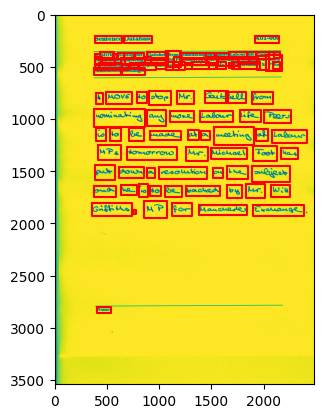

In [61]:
form_img = plt.imread(form_img_path)
size = form_img.shape[0], form_img.shape[1]
# plot_bounding_boxes_xyhw(bounding_boxes_xyhw)
mdl.plot_bounding_boxes(bounding_boxes)
plt.imshow(form_img)
plt.show()

### Testing with an image stream

In [6]:
# straight_model = load_text_detection_model()

# form_img_path = '../data/formsA-D/a01-000u.png'
# form_img = plt.imread(form_img_path)

# doc = DocumentFile.from_images(bytearray(form_img))
# doctr_coords = straight_model.det_predictor(doc)[0]
# doctr_coords

### Test with cropping

In [62]:
img_path = '../data/formsA-D/a01-000u.png'
doctr_bboxes = mdl.get_image_bounding_boxes(img_path)
img_arr = mdl.load_image(img_path)
img_size = (img_arr.shape[0], img_arr.shape[1])

bounding_boxes = mdl.format_bounding_boxes(doctr_bboxes, (1,1))
bounding_boxes_xyhw = mdl.format_bounding_boxes_xyhw(doctr_bboxes, (1,1))

2023-02-22 18:34:10.850 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/db_resnet50-adcafc63.zip
2023-02-22 18:34:12.104 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/crnn_vgg16_bn-76b7f2c6.zip


In [63]:
def reorder_bounding_boxes_coords():
    return []
bboxes = [[0.7919921875, 0.162109375,0.0146484375, 0.0546875,]]
list(map(lambda bbox: [bbox[1], bbox[0], bbox[2], bbox[3]], bboxes))

[[0.162109375, 0.7919921875, 0.0146484375, 0.0546875]]

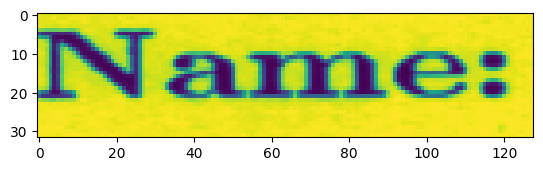

In [64]:
bboxes = [bounding_boxes[0]]
# bboxes = [bounding_boxes_xyhw[0]]
crops = tf.image.crop_and_resize(
    tf.expand_dims(img_arr, 0),
    boxes=list(map(lambda bbox: [bbox[1], bbox[0], bbox[3], bbox[2]], bboxes)),
    # boxes=bboxes,
    crop_size=[32, 128], # To resize the crop (32, 128)
    box_indices=list(range(len(bboxes)))
)

for crop in crops:
    plt.imshow(crop)
    plt.plot()

### Multiple

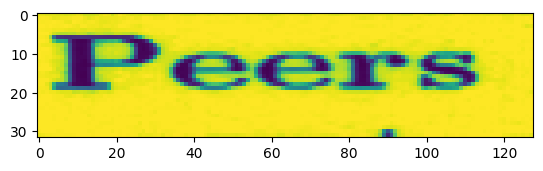

In [65]:
bboxes = bounding_boxes
crops = tf.image.crop_and_resize(
    tf.expand_dims(img_arr, 0),
    boxes=list(map(lambda bbox: [bbox[1], bbox[0], bbox[3], bbox[2]], bboxes)), # [y1, x1, y2, x2]
    crop_size=[32, 128], # To resize the crop img to (32, 128)
    box_indices=[0 for i in range(len(bboxes))] # We are always using the same img
)

# fig = plt.figure(figsize = (10,20))
# nb_figs = len(crops)
# for i in range(nb_figs):
#     fig.add_subplot(1,nb_figs, i+1)
#     plt.imshow(crops[i])
# plt.plot()

i=0
for crop in crops[0: len(crops) - 5]:
    i += 1
    if i < 3:
        continue
    plt.imshow(crop)
    plt.plot()

## Text recognition

### POC

In [66]:
df = pd.read_pickle('../pickle/df.pickle')

[]

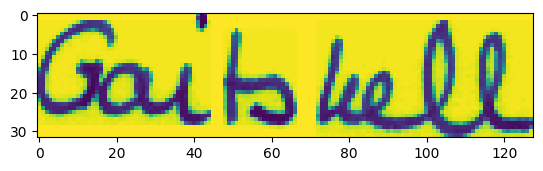

In [67]:
word_img_path = df.iloc[5].word_img_path
word_img = mdl.load_image(word_img_path, (32, 128));
plt.imshow(word_img);
plt.plot()

In [68]:
np.array([word_img]).shape

(1, 32, 128, 1)

In [69]:
reco_model = tf.keras.models.load_model("../pickle/tj_ctc_augmented_20epochs_LR-plateau", custom_objects={"CTCLoss": mdl.CTCLoss})

In [70]:
# reco_predictions = reco_model.predict(np.array([word_img]))
reco_predictions = reco_model.predict(
    np.array(word_img).reshape(1,word_img.shape[0],word_img.shape[1],1)
)

1/1 [==============================] - 0s 117ms/step


/Users/jpec/miniconda3/envs/work/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [71]:
mots = ld_util.greedy_decoder(reco_predictions, rss.charList)
print(mots)

['']


# Full model

In [87]:
import re
import os
img_path = '../data/formsA-D/a01-000u.png'
# img_path = img_path.rsplit( ".", 1 )[0]
# img_path.rsplit( /\//, 1 )[1]
img_path = os.path.basename(img_path)
img_path.rsplit( ".", 1 )[0]

'a01-000u'

In [93]:
text_detection_model = mdl.load_text_detection_model()
text_reco_model = tf.keras.models.load_model("../pickle/tj_ctc_augmented_20epochs_LR-plateau", custom_objects={"CTCLoss": mdl.CTCLoss})


2023-02-22 20:21:03.796 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/db_resnet50-adcafc63.zip
2023-02-22 20:21:05.089 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/crnn_vgg16_bn-76b7f2c6.zip


4/4 [==============================] - 0s 90ms/step


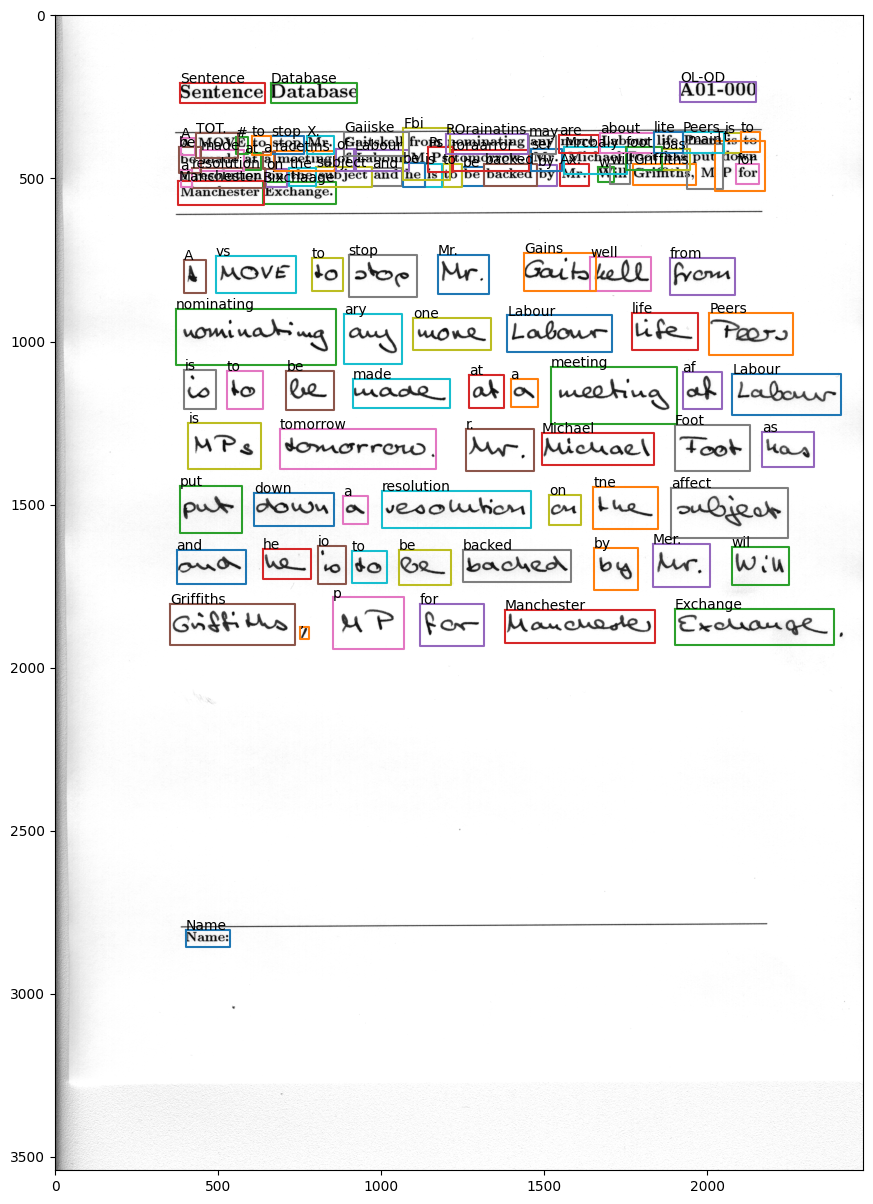

['Name', ',', 'Erchange', 'Manchester', 'for', 'Grigfiths', 'p', 'backed', 'bve', 'to', 'ond', 'by', 'wil', 'he', 'Mer.', 'io', 'a', 'auiect', 'on', 'resomtion', 'down', 'tne', 'put', 'Michael', 'as', 'r.', 'somorrow', 'Foot', 'iPs', 'made', 'Laour', 'a', 'mecting', 'at', 'af', 'be', 'to', 'is', 'mone', 'ary', 'Labour', 'Peers', 'nominating', 'life', 'from', 'A', 'kell', 'stop', 'to', 'ovs', 'Mr.', 'Gaits', 'Bixchaage', 'Manchestor', 'on', 'rosolution', 'a', 'and', 'subject', 'the', 'be', 'Grifftss', 'w', 'Ax.', 'by', 'backed', 'for', 'rill', 'to', 'is', 'be', 'racetins', 'at', 'toraarror', 'Labour', 'a', 'aade', 'zainn', 'bas', 'Mrcbaly', 'ser', 'Ttn', 'foot', 'Ps', 'of', 'be', 'A', 'eay', 'Ftbi', 'Dx.', 'stop', 'to', '#', 'are', 'ROrainatins', 'ITOT.', 'abour', 'Gaiiske', 'is', 'Peers', 'lite', 'to', 'Database', 'Sentence', 'AOL-bOD']


In [111]:
from importlib import reload 
# reload(ld_util)
# reload(pp)
# reload(rss)
# reload(rd)
# reload(mo)
reload(mdl)


form_img_path = '../data/formsA-D/a01-000u.png'
text = mdl.make_ocr(text_detection_model, text_reco_model, form_img_path, with_display=True)
print(text)